# Decision Tree

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from feature_scaler import *
from evaluation import *

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Data Pre-processing

In [3]:
df = pd.read_csv('./data/breast-cancer.csv')

encoder = LabelEncoder()
df['diagnosis'] = encoder.fit_transform(df['diagnosis'])
df = df.drop(columns=["id"], axis=1)

In [4]:
# Data split and scaling
X = df.drop(columns=["diagnosis"])
y = df['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_ss, X_test_ss = standard_scaler(X_train, X_test) # Standard Scaler
X_train_mms, X_test_mms = min_max_scaler(X_train, X_test) # Min-Max Scaler

### Removing features when the correlation between them exceeds a certain threshold

In [5]:
X_corr = X.corr(numeric_only=True).round(3)
correlation_threshold = 0.9
upper_matrix = X_corr.where(np.triu(np.ones(X_corr.shape), k=1).astype(bool))
features_to_drop = [x for x in upper_matrix.columns if any(upper_matrix[x] > correlation_threshold)]
X_corr = X.drop(X[features_to_drop], axis=1)

X_corr_train, X_corr_test = train_test_split(X_corr, test_size=0.2, random_state=42)
X_corr_train_ss, X_corr_test_ss = standard_scaler(X_corr_train, X_corr_test) # Standard Scaler
X_corr_train_mms, X_corr_test_mms = min_max_scaler(X_corr_train, X_corr_test) # Min-Max Scaler

## Implementation from Scratch

In [7]:
class TreeNode:
    def __init__(self, data, target):
        self.data = data
        self.target = target
        self.left = None
        self.right = None
        self.feature_index = None
        self.threshold = None
        self.prediction = None

def gini_impurity(y):
    classes = set(y)
    impurity = 1.0
    for cls in classes:
        p_cls = len(y[y == cls]) / len(y)
        impurity -= p_cls ** 2
    return impurity

def split_data(X, y, feature_index, threshold):
    left_mask = X[:, feature_index] <= threshold
    right_mask = ~left_mask
    return X[left_mask], y[left_mask], X[right_mask], y[right_mask]

def find_best_split(X, y):
    m, n = X.shape
    best_gini = float('inf')
    best_feature = None
    best_threshold = None

    for feature_index in range(n):
        unique_values = set(X[:, feature_index])
        for threshold in unique_values:
            X_left, y_left, X_right, y_right = split_data(X, y, feature_index, threshold)
            gini_left = gini_impurity(y_left)
            gini_right = gini_impurity(y_right)
            gini = (len(y_left) / m) * gini_left + (len(y_right) / m) * gini_right

            if gini < best_gini:
                best_gini = gini
                best_feature = feature_index
                best_threshold = threshold

    return best_feature, best_threshold

def build_tree(X, y, depth=0, max_depth=None):
    if depth == max_depth or len(set(y)) == 1:
        leaf = TreeNode(data=None, target=None)
        leaf.prediction = max(set(y), key=list(y).count)
        return leaf

    feature_index, threshold = find_best_split(X, y)
    if feature_index is None:
        leaf = TreeNode(data=None, target=None)
        leaf.prediction = max(set(y), key=list(y).count)
        return leaf

    node = TreeNode(data=X, target=y)
    node.feature_index = feature_index
    node.threshold = threshold

    X_left, y_left, X_right, y_right = split_data(X, y, feature_index, threshold)
    node.left = build_tree(X_left, y_left, depth + 1, max_depth)
    node.right = build_tree(X_right, y_right, depth + 1, max_depth)

    return node

def predict_sample(tree, sample):
    if tree.prediction is not None:
        return tree.prediction

    if sample[tree.feature_index] <= tree.threshold:
        return predict_sample(tree.left, sample)
    else:
        return predict_sample(tree.right, sample)

def predict(tree, X):
    return [predict_sample(tree, sample) for sample in X]

y = df['diagnosis'].values
X = df.drop(columns=["diagnosis"]).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for max_depth in range(3, 21):
    tree = build_tree(X_train, y_train, max_depth=max_depth)
    y_pred = predict(tree, X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Max Depth: {max_depth}, Accuracy: {accuracy:.2f}')

Max Depth: 3, Accuracy: 0.94
Max Depth: 4, Accuracy: 0.93
Max Depth: 5, Accuracy: 0.93
Max Depth: 6, Accuracy: 0.93
Max Depth: 7, Accuracy: 0.93
Max Depth: 8, Accuracy: 0.93
Max Depth: 9, Accuracy: 0.93
Max Depth: 10, Accuracy: 0.93
Max Depth: 11, Accuracy: 0.93
Max Depth: 12, Accuracy: 0.93
Max Depth: 13, Accuracy: 0.93
Max Depth: 14, Accuracy: 0.93
Max Depth: 15, Accuracy: 0.93
Max Depth: 16, Accuracy: 0.93
Max Depth: 17, Accuracy: 0.93
Max Depth: 18, Accuracy: 0.93
Max Depth: 19, Accuracy: 0.93
Max Depth: 20, Accuracy: 0.93


## Built-In

In [17]:
def calculate(X_train, X_test, y_train, y_test, X_corr_train, X_corr_test, crit, title):
    accuracy_scores = [np.array([0, 0, 0, 0]), np.array([0, 0, 0, 0])]
    accuracy_scores2 = [np.array([0, 0, 0, 0]), np.array([0, 0, 0, 0])]
    for k in range(2, 20):
        model = DecisionTreeClassifier(criterion=crit, max_depth=k)
        model2 = DecisionTreeClassifier(criterion=crit, max_depth=k)
        model.fit(X_train, y_train)
        model2.fit(X_corr_train, y_train)
        y_pred = model.predict(X_test)
        y_pred2 = model2.predict(X_corr_test)
        accuracy, f1, recall, precision, auc, cm = evaluate(y_test, y_pred)
        accuracy_scores.append(
            np.array([accuracy, f1, recall, precision])
        )
        accuracy, f1, recall, precision, auc, cm = evaluate(y_test, y_pred2)
        accuracy_scores2.append(
            np.array([accuracy, f1, recall, precision])
        )

    evalution_metrics = pd.DataFrame(accuracy_scores, columns=['Accuracy', 'F1', 'Recall', 'Precision'])
    evalution_metrics2 = pd.DataFrame(accuracy_scores2, columns=['Accuracy_Corr', 'F1_Corr', 'Recall_Corr', 'Precision_Corr'])
    print(f'Max Accuracy: {evalution_metrics["Accuracy"].max()}, for max_depth = {evalution_metrics["Accuracy"].idxmax()}')
    print(f'Max Accuracy: {evalution_metrics2["Accuracy_Corr"].max()}, for max_depth = {evalution_metrics2["Accuracy_Corr"].idxmax()}')

    plt.figure(figsize=(10, 5))
    sns.set_style("darkgrid")
    sns.lineplot(data=evalution_metrics[2:], marker='o', palette=sns.color_palette('viridis', n_colors=4)).set_xticks(range(2, 20, 2))
    sns.lineplot(data=evalution_metrics2[2:], marker='o', palette=sns.color_palette('flare', n_colors=4)).set_xticks(range(2, 20, 2))
    plt.title(title)
    plt.show()

### Without Scaling

Max Accuracy: 0.9473684210526315, for K = 3
Max Accuracy: 0.9298245614035088, for K = 9


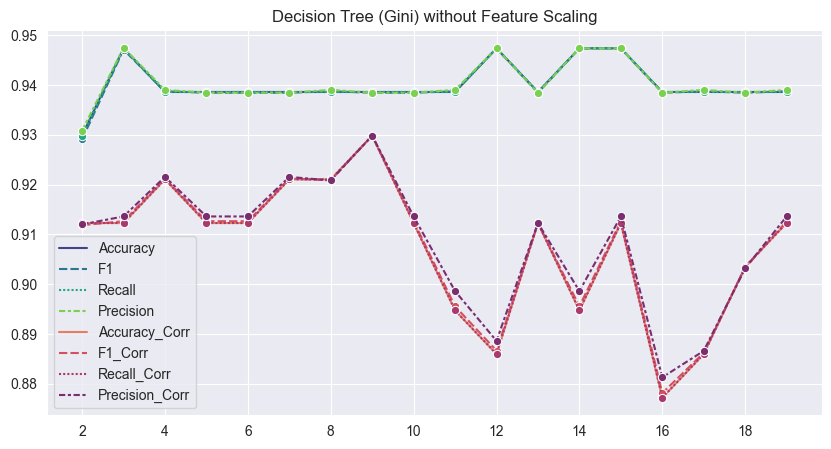

Max Accuracy: 0.9649122807017544, for K = 3
Max Accuracy: 0.9649122807017544, for K = 5


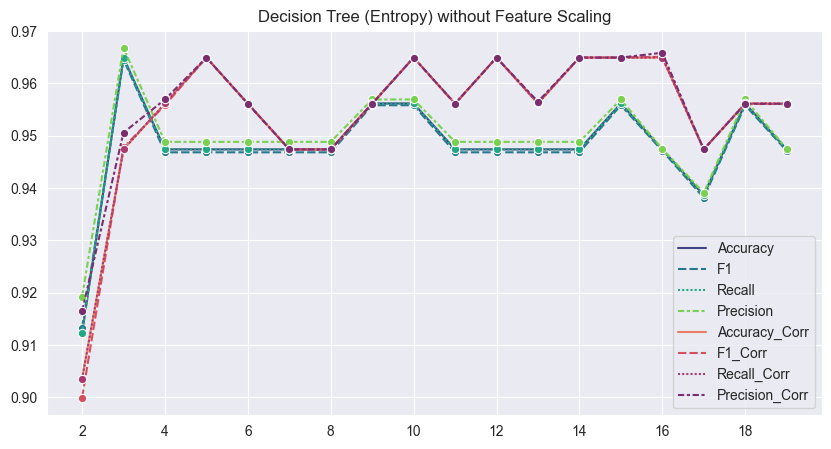

Max Accuracy: 0.956140350877193, for K = 3
Max Accuracy: 0.9736842105263158, for K = 8


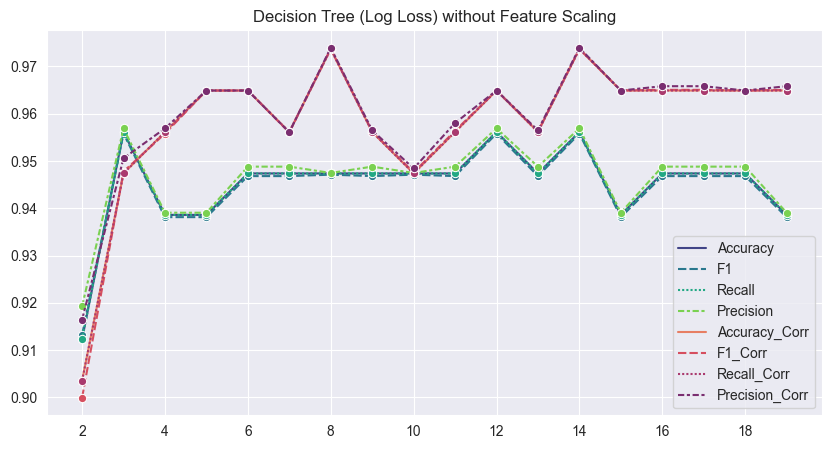

In [25]:
calculate(X_train, X_test, y_train, y_test, X_corr_train, X_corr_test, 'gini',
          'Decision Tree (Gini) without Feature Scaling')

calculate(X_train, X_test, y_train, y_test, X_corr_train, X_corr_test, 'entropy',
          'Decision Tree (Entropy) without Feature Scaling')

calculate(X_train, X_test, y_train, y_test, X_corr_train, X_corr_test, 'log_loss',
          'Decision Tree (Log Loss) without Feature Scaling')

### With Min-Max Scaling

Max Accuracy: 0.9473684210526315, for K = 5
Max Accuracy: 0.9210526315789473, for K = 4


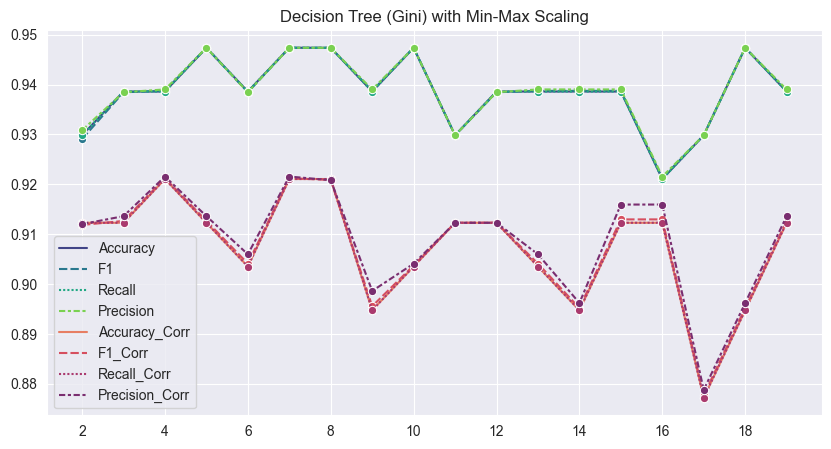

Max Accuracy: 0.9649122807017544, for K = 3
Max Accuracy: 0.9736842105263158, for K = 5


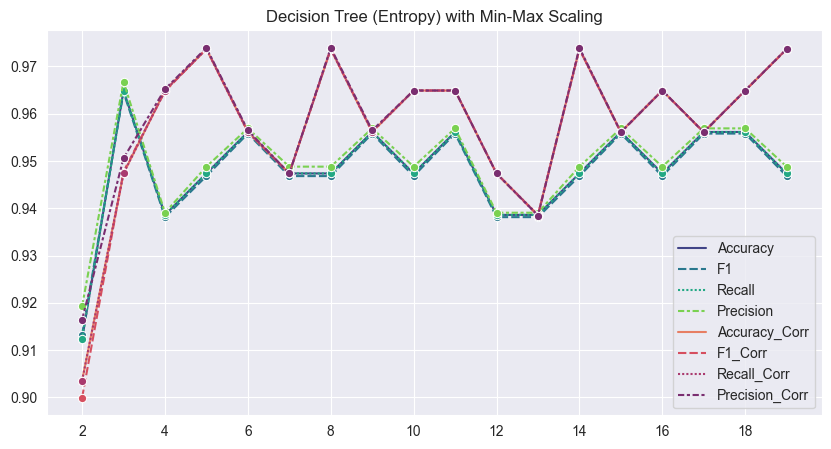

Max Accuracy: 0.9649122807017544, for K = 3
Max Accuracy: 0.9736842105263158, for K = 12


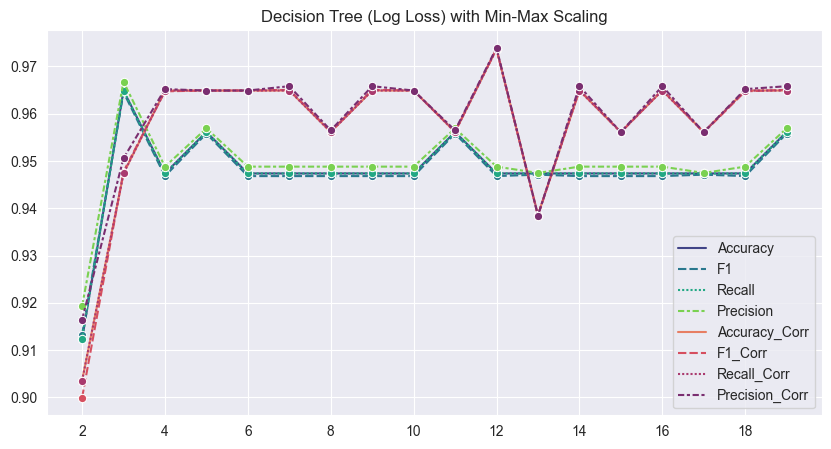

In [26]:
calculate(X_train_ss, X_test_ss, y_train, y_test, X_corr_train_ss, X_corr_test_ss, 'gini',
          'Decision Tree (Gini) with Min-Max Scaling')

calculate(X_train_ss, X_test_ss, y_train, y_test, X_corr_train_ss, X_corr_test_ss, 'entropy',
          'Decision Tree (Entropy) with Min-Max Scaling')

calculate(X_train_ss, X_test_ss, y_train, y_test, X_corr_train_ss, X_corr_test_ss, 'log_loss',
          'Decision Tree (Log Loss) with Min-Max Scaling')

In [12]:
score = []
model = DecisionTreeClassifier(criterion='gini')
model.fit(X_train_ss, y_train)
y_pred = model.predict(X_test_ss)
score.append(np.array(evaluate(y_test, y_pred, False)))

model = DecisionTreeClassifier(criterion='entropy')
model.fit(X_train_ss, y_train)
y_pred = model.predict(X_test_ss)
score.append(np.array(evaluate(y_test, y_pred, False)))

model = DecisionTreeClassifier(criterion='log_loss')
model.fit(X_train_ss, y_train)
y_pred = model.predict(X_test_ss)
score.append(np.array(evaluate(y_test, y_pred, False)))

In [13]:
model = DecisionTreeClassifier(criterion='gini')
model.fit(X_corr_train_ss, y_train)
y_pred = model.predict(X_corr_test_ss)
score.append(np.array(evaluate(y_test, y_pred, False)))

model = DecisionTreeClassifier(criterion='entropy')
model.fit(X_corr_train_ss, y_train)
y_pred = model.predict(X_corr_test_ss)
score.append(np.array(evaluate(y_test, y_pred, False)))

model = DecisionTreeClassifier(criterion='log_loss')
model.fit(X_corr_train_ss, y_train)
y_pred = model.predict(X_corr_test_ss)
score.append(np.array(evaluate(y_test, y_pred, False)))

### PCA

In [14]:
tmp_pca = [0,0,0,0,0,0]
tmp_pca2 = [0,0,0,0,0,0]

import warnings
for n in range(2, 20):
    pca = PCA(n_components=n)
    pca.fit(X_train)

    warnings.filterwarnings("ignore")
    X_train_pca = pca.transform(X_train_mms)
    X_test_pca = pca.transform(X_test_mms)

    model = DecisionTreeClassifier()
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    tmp = evaluate(y_test, y_pred, False)
    if tmp_pca[0] < tmp[0]:
        tmp_pca = tmp

    pca = PCA(n_components=n)
    pca.fit(X_corr_train_ss)

    warnings.filterwarnings("ignore")
    X_train_pca = pca.transform(X_corr_train_mms)
    X_test_pca = pca.transform(X_corr_test_mms)

    model = DecisionTreeClassifier()
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    tmp = evaluate(y_test, y_pred, False)
    if tmp_pca2[0] < tmp[0]:
        tmp_pca2 = tmp

score.append(tmp_pca)
score.append(tmp_pca2)

In [15]:
tmp_pca = [0,0,0,0,0,0]
tmp_pca2 = [0,0,0,0,0,0]

import warnings
for n in range(2, 20):
    pca = PCA(n_components=n)
    pca.fit(X_train)

    warnings.filterwarnings("ignore")
    X_train_pca = pca.transform(X_train_ss)
    X_test_pca = pca.transform(X_test_ss)

    model = DecisionTreeClassifier()
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    tmp = evaluate(y_test, y_pred, False)
    if tmp_pca[0] < tmp[0]:
        tmp_pca = tmp

    pca = PCA(n_components=n)
    pca.fit(X_corr_train_ss)

    warnings.filterwarnings("ignore")
    X_train_pca = pca.transform(X_corr_train_ss)
    X_test_pca = pca.transform(X_corr_test_ss)

    model = DecisionTreeClassifier()
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    tmp = evaluate(y_test, y_pred, False)
    if tmp_pca2[0] < tmp[0]:
        tmp_pca2 = tmp

score.append(tmp_pca)
score.append(tmp_pca2)

In [16]:
pd.DataFrame(score,
    index=['Gini Standard Scaler', 'Entopy Standard Scaler Corr', 'Log Loss Standard Scaler', 'Gini Standard Scaler Corr', 'Entopy Standard Scaler', 'Log Loss Standard Scaler Corr', 'PCA Min-Max Scaler', 'PCA Min-MAx Scaler Corr', 'PCA Standard Scaler', 'PCA Standard Scaler Corr'], 
    columns=['Accuracy', 'F1', 'Recall', 'Precision', 'AUC', 'Confusion Matrix'])

,Accuracy,F1,Recall,Precision,AUC,Confusion Matrix
Gini Standard Scaler,0.929825,0.930121,0.929825,0.931011,0.929905,"[[66, 5], [3, 40]]"
Entopy Standard Scaler Corr,0.938596,0.938122,0.938596,0.939059,0.927776,"[[69, 2], [5, 38]]"
Log Loss Standard Scaler,0.956140,0.955801,0.956140,0.956905,0.946446,"[[70, 1], [4, 39]]"
Gini Standard Scaler Corr,0.912281,0.912281,0.912281,0.912281,0.906649,"[[66, 5], [5, 38]]"
Entopy Standard Scaler,0.956140,0.956036,0.956140,0.956088,0.951032,"[[69, 2], [3, 40]]"
Log Loss Standard Scaler Corr,0.964912,0.964912,0.964912,0.964912,0.962660,"[[69, 2], [2, 41]]"
PCA Min-Max Scaler,0.964912,0.964912,0.964912,0.964912,0.962660,"[[69, 2], [2, 41]]"
PCA Min-MAx Scaler Corr,0.885965,0.885084,0.885965,0.885520,0.871765,"[[66, 5], [8, 35]]"
PCA Standard Scaler,0.956140,0.956036,0.956140,0.956088,0.951032,"[[69, 2], [3, 40]]"
PCA Standard Scaler Corr,0.868421,0.867404,0.868421,0.867674,0.853095,"[[65, 6], [9, 34]]"
